#### Import library

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
# Untuk encoding kategori
from sklearn.preprocessing import LabelEncoder
# Supaya grafik menampilkan grid
plt.rcParams['axes.grid'] = True

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

ModuleNotFoundError: No module named 'pandas'

## Praprosess data

In [ ]:
train = pd.read_csv('data_train.csv', parse_dates=['tanggal_waktu'])
test  = pd.read_csv('data_test.csv',  parse_dates=['tanggal_waktu'])
submission = pd.read_csv('submission_format.csv')

In [ ]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 24336 non-null  int64         
 1   tanggal_waktu      24336 non-null  datetime64[ns]
 2   suhu               24336 non-null  float64       
 3   beban_listrik      24336 non-null  float64       
 4   kecepatan_angin    24336 non-null  float64       
 5   tekanan_udara      24336 non-null  float64       
 6   dampak_lingkungan  24336 non-null  object        
 7   konsumsi_listrik   24283 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.5+ MB


,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik
count,24336.000000,24336,24336.000000,24336.000000,24336.000000,24336.000000,24283.000000
mean,16027.381657,2023-07-16 19:22:53.964496896,25.161082,-1.783510,23.631823,986.012964,532.445209
min,0.000000,2021-09-17 00:00:00,12.700000,-32.900000,1.075000,953.000000,174.000000
25%,8051.750000,2022-08-18 11:45:00,21.100000,-10.700000,3.165000,977.000000,219.000000
50%,16079.500000,2023-07-18 23:30:00,25.800000,-1.400000,6.670000,986.000000,270.000000
75%,24155.250000,2024-06-19 11:15:00,29.400000,7.900000,22.700000,995.000000,342.000000
max,32183.000000,2025-05-19 23:00:00,35.300000,18.600000,586.600000,1024.000000,99999.000000
std,9299.957517,NaN,4.888658,10.521302,46.781818,12.130831,4826.021227


In [ ]:
# Konversi kolom tanggal_waktu menjadi datetime
train['tanggal_waktu'] = pd.to_datetime(train['tanggal_waktu'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
train

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,dampak_lingkungan,konsumsi_listrik
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,A,216.0
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,A,210.0
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,A,225.0
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,A,216.0
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,A,222.0
...,...,...,...,...,...,...,...,...
24331,32179,2025-05-19 19:00:00,27.8,10.7,4.505,981.0,A,186.0
24332,32180,2025-05-19 20:00:00,27.8,7.9,4.005,976.0,A,198.0
24333,32181,2025-05-19 21:00:00,27.8,10.0,5.920,989.0,A,192.0
24334,32182,2025-05-19 22:00:00,27.0,9.3,3.040,982.0,A,183.0


In [ ]:
# Membuat kolom ID menjadi index
train = train.set_index('tanggal_waktu')
train

,ID,suhu,beban_listrik,kecepatan_angin,tekanan_udara,dampak_lingkungan,konsumsi_listrik
tanggal_waktu,,,,,,,
2021-09-17 00:00:00,0,15.9,-17.1,571.910,1003.0,A,216.0
2021-09-17 01:00:00,1,15.5,-19.3,575.040,996.0,A,210.0
2021-09-17 02:00:00,2,15.1,-20.0,578.435,1000.0,A,225.0
2021-09-17 03:00:00,3,15.9,-17.1,582.580,995.0,A,216.0
2021-09-17 04:00:00,4,15.9,-19.3,586.600,1005.0,A,222.0
...,...,...,...,...,...,...,...
2025-05-19 19:00:00,32179,27.8,10.7,4.505,981.0,A,186.0
2025-05-19 20:00:00,32180,27.8,7.9,4.005,976.0,A,198.0
2025-05-19 21:00:00,32181,27.8,10.0,5.920,989.0,A,192.0


In [ ]:
# Ganti error measurement
train['konsumsi_listrik'] = train['konsumsi_listrik'].replace(99999, np.nan)
# Interpolasi linier (hindari chained assignment dengan inplace)
train['konsumsi_listrik'] = train['konsumsi_listrik'].interpolate(method='time')

# Encode kategori dampak_lingkungan
le = LabelEncoder()
train['dampak_lingkungan_enc'] = le.fit_transform(train['dampak_lingkungan'])

# Cek missing lainnya
print("Missing per kolom:\n", train.isna().sum())

Missing per kolom:
 ID                       0
suhu                     0
beban_listrik            0
kecepatan_angin          0
tekanan_udara            0
dampak_lingkungan        0
konsumsi_listrik         0
dampak_lingkungan_enc    0
dtype: int64


## EDA

### 4.1 Statistik Deskriptif

In [ ]:
desc = train.describe()
print(desc)

                 ID          suhu  beban_listrik  kecepatan_angin  \
count  24336.000000  24336.000000   24336.000000     24336.000000   
mean   16027.381657     25.161082      -1.783510        23.631823   
std     9299.957517      4.888658      10.521302        46.781818   
min        0.000000     12.700000     -32.900000         1.075000   
25%     8051.750000     21.100000     -10.700000         3.165000   
50%    16079.500000     25.800000      -1.400000         6.670000   
75%    24155.250000     29.400000       7.900000        22.700000   
max    32183.000000     35.300000      18.600000       586.600000   

       tekanan_udara  konsumsi_listrik  dampak_lingkungan_enc  
count   24336.000000      24336.000000           24336.000000  
mean      986.012964        298.465853               0.089497  
std        12.130831        107.132152               0.402635  
min       953.000000        174.000000               0.000000  
25%       977.000000        219.000000               0.000

### 4.2 Visualisasi Seri Waktu Konsumsi Listrik


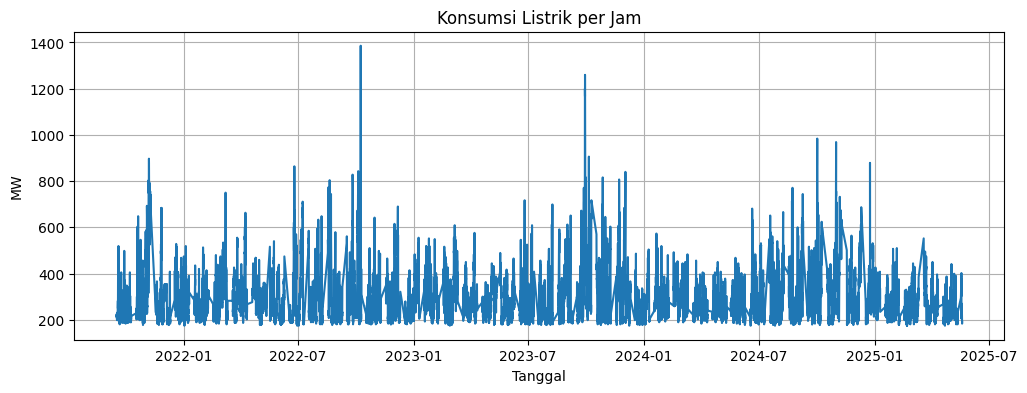

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train.index, train['konsumsi_listrik'])
plt.title('Konsumsi Listrik per Jam')
plt.xlabel('Tanggal')
plt.ylabel('MW')
plt.show()

### 4.3 Distribusi Nilai

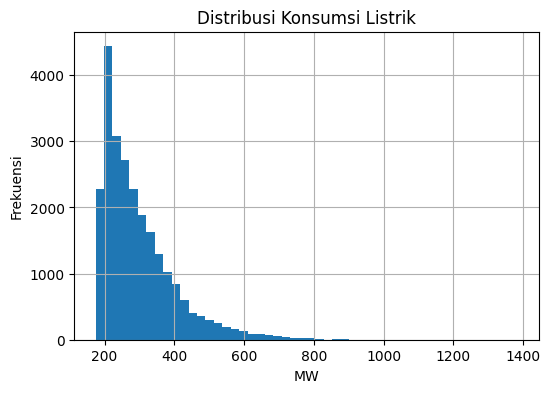

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(train['konsumsi_listrik'], bins=50)
plt.title('Distribusi Konsumsi Listrik')
plt.xlabel('MW')
plt.ylabel('Frekuensi')
plt.show()

### 4.4 Korelasi dengan Variabel Cuaca

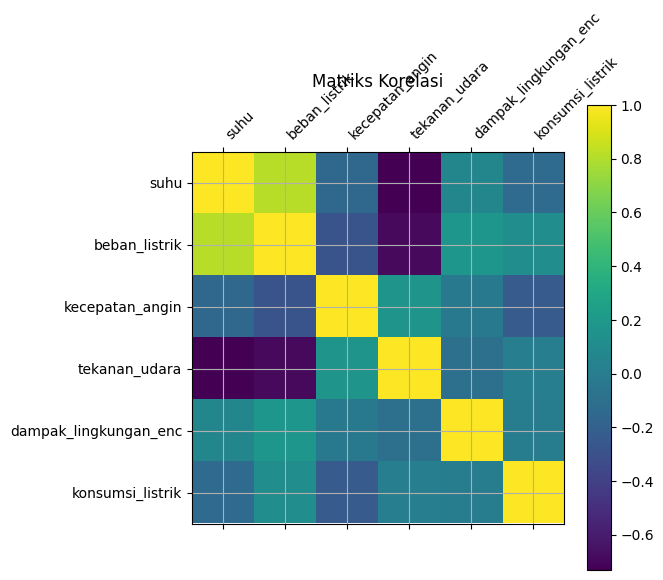

In [ ]:
# Pilih fitur numerik
features = ['suhu', 'beban_listrik', 'kecepatan_angin', 'tekanan_udara', 'dampak_lingkungan_enc']

corr = train[features + ['konsumsi_listrik']].corr()

plt.figure(figsize=(6,6))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='left')
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title('Matriks Korelasi', y=1.15)
plt.show()

### 4.5 Musiman 24 Jam (Rata-rata)

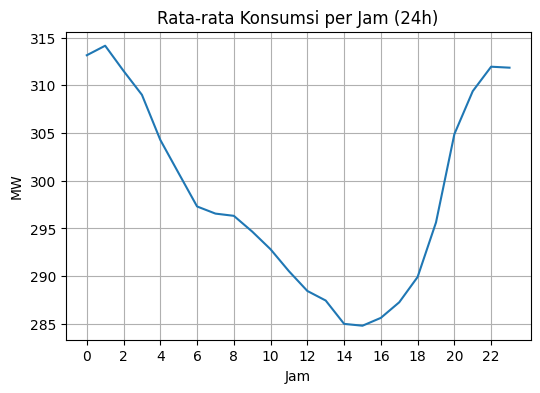

In [ ]:
avg_24 = train['konsumsi_listrik'].groupby(train.index.hour).mean()
plt.figure(figsize=(6,4))
plt.plot(avg_24.index, avg_24.values)
plt.title('Rata-rata Konsumsi per Jam (24h)')
plt.xlabel('Jam')
plt.ylabel('MW')
plt.xticks(range(0,24,2))
plt.show()

### 4.6. Analisis Deret Waktu

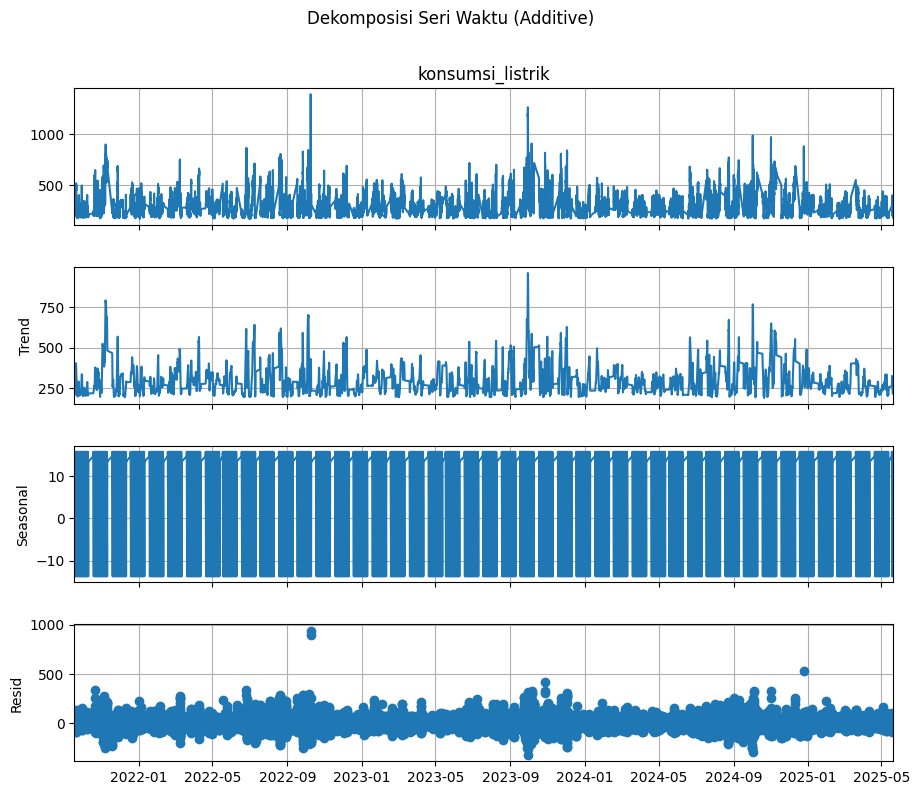

In [ ]:
# Ambil seri waktu
ts = train['konsumsi_listrik']

# 1. Decompose seri (additive)
decomp = seasonal_decompose(ts, model='additive', period=24)
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.suptitle('Dekomposisi Seri Waktu (Additive)', y=1.02)
plt.show()

## 5. Model Time Series


In [ ]:
# Split data train/validation
n = len(train)
train_size = int(0.8 * n)
y_train = train['konsumsi_listrik'].iloc[:train_size]
y_val   = train['konsumsi_listrik'].iloc[train_size:]

In [ ]:
# Method 1: ARIMA(1,1,1)
model1 = ARIMA(y_train, order=(1,1,1)).fit()
pred1  = model1.forecast(steps=len(y_val))
rmse1  = sqrt(mean_squared_error(y_val, pred1))

C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and 

In [ ]:
# Method 2: Holt-Winters (additive)
model2 = ExponentialSmoothing(
    y_train, trend='add', seasonal='add', seasonal_periods=24
).fit(optimized=True)
pred2 = model2.forecast(steps=len(y_val))
rmse2 = sqrt(mean_squared_error(y_val, pred2))

C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a sup

In [ ]:
# Siapkan exogenous features dan pastikan numeric\ n
exog = pd.concat([
    train[['suhu','beban_listrik','kecepatan_angin','tekanan_udara']],
    pd.get_dummies(train['dampak_lingkungan'], prefix='d').astype(float)
], axis=1).astype(float)
exog_train = exog.iloc[:train_size]
exog_val   = exog.iloc[train_size:]
# Fit SARIMAX dengan data eksogen
model3 = SARIMAX(
    y_train, exog=exog_train, order=(1,1,1),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)
pred3 = model3.forecast(steps=len(y_val), exog=exog_val)
rmse3 = sqrt(mean_squared_error(y_val, pred3))

C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer i

In [ ]:
results = pd.DataFrame({
    'Metode': ['ARIMA(1,1,1)', 'Holt-Winters', 'SARIMAX exog'],
    'RMSE': [rmse1, rmse2, rmse3]
})
print(results)

         Metode         RMSE
0  ARIMA(1,1,1)   378.670790
1  Holt-Winters  3785.444237
2  SARIMAX exog   374.784173


In [ ]:
# Siapkan data Prophet
df_prophet = train['konsumsi_listrik'].reset_index()[['tanggal_waktu','konsumsi_listrik']]
df_prophet.columns = ['ds','y']
df_train = df_prophet.iloc[:train_size]
df_val   = df_prophet.iloc[train_size:]


In [ ]:
# Fit & prediksi Prophet
model_prophet = Prophet()
model_prophet.fit(df_train)
future = model_prophet.make_future_dataframe(periods=len(df_val), freq='H')
forecast = model_prophet.predict(future)
pred_prophet = forecast['yhat'].iloc[-len(df_val):].values
rmse_prophet = sqrt(mean_squared_error(df_val['y'], pred_prophet))


12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
results.loc[len(results)] = ['Prophet', rmse_prophet]
print(results)

         Metode         RMSE
0  ARIMA(1,1,1)   378.670790
1  Holt-Winters  3785.444237
2  SARIMAX exog   374.784173
3       Prophet   115.833920


In [ ]:
# Pilih model terbaik (misal Prophet) untuk prediksi test set
# Fit ulang pada seluruh data train (full series)
full_prophet = Prophet()
full_prophet.fit(df_prophet)

12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Buat dataframe future untuk periode test
future_test = full_prophet.make_future_dataframe(periods=len(test), freq='H', include_history=False)
forecast_test = full_prophet.predict(future_test)


C:\Users\Rifqi Alfareza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
# Ambil nilai prediksi
test_preds = forecast_test['yhat'].values

In [ ]:
# Load format submission
df_submit = pd.read_csv('submission_format.csv')  # atau 'submission_format.csv' sesuai file

# Assign hasil prediksi pada kolom target sesuai format

In [ ]:
# Assign hasil prediksi pada kolom target sesuai format
# Contoh kolom: 'konsumsi_listrik' atau sesuai header sample_submission
col_target = [c for c in df_submit.columns if c not in ['ID', 'id']][0]
df_submit[col_target] = test_preds


In [ ]:
# Export ke CSV
df_submit.to_csv('submission.csv', index=False)
print("File submission.csv berhasil dibuat.")

File submission.csv berhasil dibuat.
